# Canny Edge Detector

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from scipy import ndimage
import cv2 as cv

## show image and read RBG values

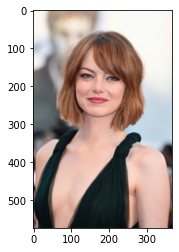

In [22]:
rbg = mpimg.imread("face_picture.jpg")
rbg = np.array(rbg)
plt.imshow(rbg)

In [23]:
print(rbg)
height = rbg.shape[0]
width = rbg.shape[1]
print(height)
print(width)

[[[  0   1   0]
  [248 247 243]
  [251 248 243]
  ...
  [248 245 238]
  [248 245 238]
  [248 245 238]]

 [[  1   0   0]
  [250 246 243]
  [250 247 242]
  ...
  [248 245 238]
  [248 245 238]
  [248 245 238]]

 [[  1   0   0]
  [250 246 243]
  [250 247 242]
  ...
  [249 246 239]
  [248 245 238]
  [248 245 238]]

 ...

 [[115  91  87]
  [118  93  88]
  [121  93  89]
  ...
  [ 11  10  15]
  [ 11  11  13]
  [  1   1   1]]

 [[114  91  85]
  [118  93  86]
  [123  94  88]
  ...
  [ 10   9  14]
  [ 10  10  12]
  [  0   0   2]]

 [[108  85  77]
  [114  87  78]
  [119  90  82]
  ...
  [ 10   9  14]
  [ 10  10  12]
  [  0   0   2]]]
574
366


## Convert Color image to grayscale

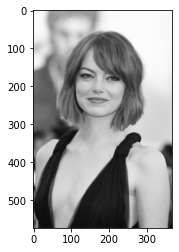

In [24]:
def rbg_to_grayscale(rbg):
    '''
    Compute gray values

    Args:
        rbg : rbg values

    Returns:
        gray values of the image
    '''
    height = rbg.shape[0]
    width = rbg.shape[1]
    gray_values = []

    for i in range(height):
        temp = []
        for j in range(width):
            pixel_value = rbg[i , j]
            gray_value = sum(pixel_value) / len(pixel_value)
            temp.append(gray_value)
        gray_values.append(temp)

    return np.array(gray_values)

gray_scale = rbg_to_grayscale(rbg)
plt.imshow(gray_scale, 'gray')

## Apply Gaussian Smoothing

$size = (2k+1) × (2k+1)$

# <center> $H_{i,j} = \frac{1}{2\pi \sigma^2} exp(-\frac{(i-(k+1))^2 + (j-(k+1))^2}{2\sigma^2})$

(574, 366)


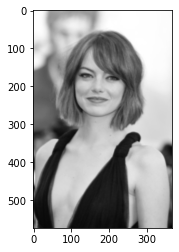

In [25]:
K = 2
Sigma = 2
def generate_gaussian_filter(k, sigma):
    filter = np.zeros((2 * k + 1, 2 * k + 1))
    for i in range(2 * k + 1):
        for j in range(2 * k + 1):
            x = i + 1 ; y = j + 1
            value = 1 / (2 * math.pi * (sigma ** 2)) * np.exp(-1 * 0.5 * (x**2 + y**2) / (sigma**2))
            filter[i , j] = value
    return filter

gaussian_filter = generate_gaussian_filter(K, Sigma)

blurred_img = ndimage.convolve(gray_scale , gaussian_filter)
print(blurred_img.shape)
plt.imshow(blurred_img , 'gray')

## Calculate Gradient using Sobel Filter

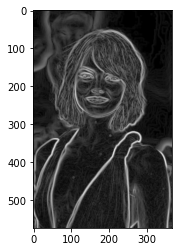

In [26]:
x_operator = np.array([[-1 , 0 , 1],
                       [-2 , 0 , 2],
                       [-1 , 0 , 1]])

y_operator = np.array([[1 , 2 , 1],
                       [0 , 0 , 0],
                       [-1 , -2 , -1]])

# convolve image with x operator and y operator
Image_X = ndimage.convolve(blurred_img , x_operator)
Image_Y = ndimage.convolve(blurred_img , y_operator)

# calculate magnitude
mag = np.hypot(Image_X , Image_Y)
mag = np.sqrt(mag)

# calculate theta
theta = np.arctan2(Image_Y , Image_X)

# to show the image, we need to scale gray scale values
temp = (255 / mag.max()) * mag
plt.imshow(temp , 'gray')


## Apply Laplacian on the direction of Gradient (non-max suppression)

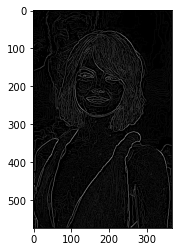

In [27]:

def non_max_suppression(mag , theta):
    '''
    Return the Gradient matrix after non max supression

    Args:
        mag : magnitude of the gradient matrix
        theta : angle (in radians)
    '''

    height = mag.shape[0]
    width = mag.shape[1]
    suppression_matrix = np.zeros((height , width))

    # convert angle to degrees
    # make sure it is [0 , 180]
    theta = (180 / math.pi) * theta
    theta[theta < 0] += 180

    for i in range(1 , height - 1):
        for j in range(1 , width - 1):
            angle = theta[i , j]
            if (0 <= angle < 30) or (150 < angle <= 180):
                n1 = mag[i,j+1] ; n2 = mag[i,j-1]
            elif (30 <= angle < 60):
                n1 = mag[i-1,j+1] ; n2 = mag[i+1,j-1]
            elif (60 <= angle < 120):
                n1 = mag[i-1,j] ; n2 = mag[i+1,j]
            else:
                n1 = mag[i-1,j-1] ; n2 = mag[i+1,j+1]

            if (mag[i , j] >= n1) and (mag[i , j] >= n2):
                suppression_matrix[i , j] = mag[i , j]


    return suppression_matrix

suppressed_matrix = non_max_suppression(mag , theta)

# show image
temp = (255 / suppressed_matrix.max()) * suppressed_matrix
plt.imshow(temp , 'gray')

## Hysteresis Tracing

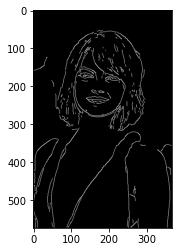

In [28]:
def threshold(img, highratio = 0.4 , lowratio = 0.5):
    highvalue = img.max() * highratio
    lowvalue = highvalue * lowratio
    height , width = img.shape

    # strong = 255
    # Weak = 10
    # non-relavent = 0

    ans = np.zeros((height , width))

    for i in range(1 , height - 1):
        for j in range(1 , width - 1):
            if img[i,j] <= lowvalue:
                ans[i,j] = 0
            elif img[i,j] >= highvalue:
                ans[i,j] = 255
            else:
                ans[i,j] = 10

    return ans


def hysteresis_tracing(img):
    height , width = img.shape

    ans = np.zeros((height , width))

    for i in range(1 , height - 1):
        for j in range(1 , width - 1):
            if img[i,j] == 255:
                ans[i,j] = 255
            elif img[i,j] == 0:
                ans[i,j] = 0
            else:
                if img[i-1,j-1] == 255:
                    ans[i,j] = 255
                elif img[i-1,j] == 255:
                    ans[i,j] = 255
                elif img[i-1,j+1] == 255:
                    ans[i,j] = 255
                elif img[i,j-1] == 255:
                    ans[i,j] = 255
                elif img[i,j+1] == 255:
                    ans[i,j] = 255
                elif img[i+1,j-1] == 255:
                    ans[i,j] = 255
                elif img[i+1,j] == 255:
                    ans[i,j] = 255
                elif img[i+1,j+1] == 255:
                    ans[i,j] = 255
                else:
                    ans[i,j] = 0
    return ans

thresholded_matrix = threshold(suppressed_matrix)
final_result = hysteresis_tracing(thresholded_matrix)
plt.imshow(final_result,'gray')

## Put everything together in a class

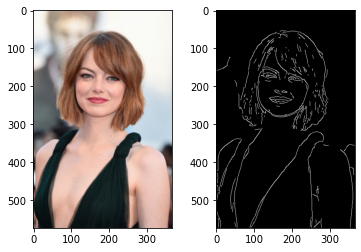

In [29]:
class Canny_Detector():

    def __init__(self,):
        # image parameters
        self.height = None
        self.width = None
        self.rgb = None

        # parameters about Gaussian
        self.sigma = 2
        self.gaussian_filter_size = 5

        # thresholding parameters
        self.highratio = 0.4
        self.lowratio = 0.5
        self.strong = 255
        self.weak = 100
        self.non_relevant = 0


    def __rgb_to_grayscale(self, rgb):
        gray_values = []

        for i in range(self.height):
            temp = []
            for j in range(self.width):
                pixel_value = self.rgb[i , j]
                gray_value = sum(pixel_value) / len(pixel_value)
                temp.append(gray_value)
            gray_values.append(temp)
        return np.array(gray_values)

    def __generate_gaussian_filter(self):
        k = (self.gaussian_filter_size - 1) / 2 ; k = int(k)
        filter = np.zeros((2 * k + 1, 2 * k + 1))
        for i in range(2 * k + 1):
            for j in range(2 * k + 1):
                x = i + 1 ; y = j + 1
                value = 1 / (2 * math.pi * (self.sigma ** 2)) * np.exp(-1 * 0.5 * (x**2 + y**2) / (self.sigma**2))
                filter[i , j] = value
        return filter

    def __apply_gaussian_filter(self, img):
        gf = self.__generate_gaussian_filter()
        return ndimage.convolve(img , gf)

    def __calculate_gradient(self, img):
        x_operator = np.array([[-1 , 0 , 1],
                               [-2 , 0 , 2],
                               [-1 , 0 , 1]])

        y_operator = np.array([[1 , 2 , 1],
                               [0 , 0 , 0],
                               [-1 , -2 , -1]])

        # convolve image with x operator and y operator
        Image_X = ndimage.convolve(img , x_operator)
        Image_Y = ndimage.convolve(img , y_operator)

        # calculate magnitude
        mag = np.hypot(Image_X , Image_Y)
        mag = np.sqrt(mag)

        # calculate theta
        theta = np.arctan2(Image_Y , Image_X)

        return mag , theta

    def __non_max_suppression(self, mag , theta):

        # convert angle to degrees
        # make sure it is [0 , 180]
        theta = (180 / math.pi) * theta
        theta[theta < 0] += 180

        ans = np.zeros((self.height , self.width))

        for i in range(1 , self.height - 1):
            for j in range(1 , self.width - 1):
                angle = theta[i , j]
                if (0 <= angle < 30) or (150 < angle <= 180):
                    n1 = mag[i,j+1] ; n2 = mag[i,j-1]
                elif (30 <= angle < 60):
                    n1 = mag[i-1,j+1] ; n2 = mag[i+1,j-1]
                elif (60 <= angle < 120):
                    n1 = mag[i-1,j] ; n2 = mag[i+1,j]
                else:
                    n1 = mag[i-1,j-1] ; n2 = mag[i+1,j+1]

                if (mag[i , j] >= n1) and (mag[i , j] >= n2):
                    ans[i , j] = mag[i , j]

        return ans

    def __thresholding(self, img):
        highvalue = img.max() * self.highratio
        lowvalue = highvalue * self.lowratio

        ans = np.zeros((self.height , self.width))

        for i in range(1 , self.height - 1):
            for j in range(1 , self.width - 1):
                if img[i,j] >= highvalue:
                    ans[i,j] = self.strong
                elif img[i,j] <= lowvalue:
                    ans[i,j] = self.non_relevant
                else:
                    ans[i,j] = self.weak

        return ans

    def __mark_strong(self, img, i, j):
        # check if we should make pixel i , j strong
        for x in range(i-1, i+2):
            for y in range(j-1 , j+2):
                if not (x==i and y==j):
                    if img[x, y] == self.strong:
                        return True
        return False

    def __hysteresis_tracing(self, img):

        ans = np.zeros((self.height , self.width))

        for i in range(1 , self.height - 1):
            for j in range(1 , self.width - 1):
                if img[i,j] == 255:
                    ans[i,j] = 255
                elif img[i,j] == 0:
                    ans[i,j] = 0
                else:
                    if self.__mark_strong(img , i , j):
                        ans[i,j] = 255
                    else:
                        ans[i,j] = 0
        return ans

    # Input is RGB Values
    def detect(self, img):
        # set image parameters
        self.rgb = img
        self.height = self.rgb.shape[0]
        self.width = self.rgb.shape[1]

        # convert to gray scale
        temp = self.__rgb_to_grayscale(self.rgb)

        # apply gaussian
        temp = self.__apply_gaussian_filter(temp)

        # calculate gradient
        mag , theta = self.__calculate_gradient(temp)

        # non max suppression
        temp = self.__non_max_suppression(mag , theta)

        # thresholding
        temp = self.__thresholding(temp)

        # tracing
        temp = self.__hysteresis_tracing(temp)

        return temp


rgb = mpimg.imread("face_picture.jpg")
rgb = np.array(rgb)
detector = Canny_Detector()
result = detector.detect(rgb)

plt.subplot(121) ; plt.imshow(rgb)
plt.subplot(122) ; plt.imshow(result , 'gray')

## Using openCV API

(Text(0.5, 1.0, 'Edge Image'), ([], []), ([], []))

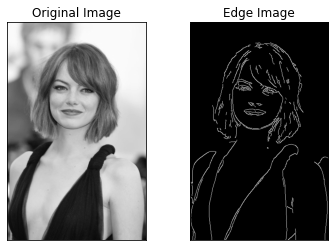

In [30]:
img = cv.imread("face_picture.jpg", cv.IMREAD_GRAYSCALE)
edges = cv.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])